In [114]:
import numpy as np
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.timeseries import TimeSeries
import pandas as pd 
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import astropy.units as u
from sunpy.time import parse_time
from sunpy.coordinates.ephemeris import get_horizons_coord


In [115]:
# Download data from Helio4cast 

#Limit to search for for the Sun-Earth line i.e  -20 to 20 degrees on the heeq 

url='https://helioforecast.space/static/sync/icmecat/HELIO4CAST_ICMECAT_v23.csv' # This needs updating as the catalogue updates 
ic=pd.read_csv(url)
ic=ic.drop(columns='Unnamed: 0') 


sun_earth_threshold = 20 # The range for the Sun-Earth line

sun_earth_cmes = ic[(ic["mo_sc_long_heeq"] >= -sun_earth_threshold) & (ic["mo_sc_long_heeq"] <= sun_earth_threshold)]

# Filter the data that's needed from the CME's on the Sun-Earth line - Can add more columns to this if needed 
filtered_cmes = sun_earth_cmes[
    ["icmecat_id", "icme_start_time","icme_duration", "icme_speed_mean", "sc_insitu", "mo_start_time", "mo_end_time", "icme_bmax", "mo_bzmean",
     "mo_sc_heliodistance", "mo_sc_long_heeq"]
]

# Saves the filtered data when needed  
# filtered_cmes.to_csv("Sun_Earth_Line_CMEs_Filtered.csv", index=False)

In [116]:
## Filters the ICMECAT by a desired date and on the Sun-Earth line 


# Date filter and ensure it's timezone-aware
date_threshold = pd.Timestamp("2018-08-01", tz="UTC")

sun_earth_cmes = ic[(ic["mo_sc_long_heeq"] >= -sun_earth_threshold) & (ic["mo_sc_long_heeq"] <= sun_earth_threshold)]

# Filter CMEs within the Sun-Earth line
sun_earth_cmes = ic[
    (ic["mo_sc_long_heeq"] >= -sun_earth_threshold) & 
    (ic["mo_sc_long_heeq"] <= sun_earth_threshold)].copy()  

# Convert 'mo_start_time' to datetime and ensure it's in UTC
sun_earth_cmes["mo_start_time"] = pd.to_datetime(sun_earth_cmes["mo_start_time"], utc=True)

# Further filter for CMEs after August 2018 and at distances < 1 AU
filtered_cmes_aug18 = sun_earth_cmes[
    (sun_earth_cmes["mo_start_time"] >= date_threshold) & 
    (sun_earth_cmes["mo_sc_heliodistance"] < 0.9)].copy() # Filters through the sun_earth_cmes 
                                                        # where Heliocentric distance of the spacecraft is < 0.9 au




In [117]:
# Select the relevant columns
filtered_cmes_aug18 = filtered_cmes_aug18[
  ["icmecat_id", "sc_insitu", "icme_start_time","icme_speed_mean", "icme_duration", "mo_start_time", "mo_end_time", "mo_sc_long_heeq", "mo_sc_heliodistance", "icme_bmax", "mo_bzmean",
     ]]
# Save file if needed
#filtered_cmes_aug18.to_csv("filtered_cmes_aug18.csv", index=False)


In [118]:
# Filter for PSP and Solar Orbiter - Can add more spacecraft if needed 
target_spacecraft = ['PSP', 'SolarOrbiter']
PSP_SolOrb_CMEs = filtered_cmes_aug18[filtered_cmes_aug18['sc_insitu'].isin(target_spacecraft)].copy()
# Print the dataframe 
PSP_SolOrb_CMEs

,icmecat_id,sc_insitu,icme_start_time,icme_speed_mean,icme_duration,mo_start_time,mo_end_time,mo_sc_long_heeq,mo_sc_heliodistance,icme_bmax,mo_bzmean
12,ICME_SOLO_MOESTL_20241108_01,SolarOrbiter,2024-11-08T18:59Z,379.8,9.23,2024-11-08 18:59:00+00:00,2024-11-09T04:13Z,-5.56,0.7205,26.1,-9.1
14,ICME_SOLO_MOESTL_20241107_02,SolarOrbiter,2024-11-07T12:55Z,384.8,22.55,2024-11-07 12:55:00+00:00,2024-11-08T11:28Z,-5.94,0.7083,29.2,-9.1
15,ICME_SOLO_MOESTL_20241107_01,SolarOrbiter,2024-11-07T03:42Z,341.8,7.82,2024-11-07 05:25:00+00:00,2024-11-07T11:31Z,-6.04,0.7052,24.4,-7.4
37,ICME_PSP_MOESTL_20240915_01,PSP,2024-09-15T14:32Z,596.9,4.97,2024-09-15 16:37:00+00:00,2024-09-15T19:30Z,-1.75,0.4874,46.3,5.0
42,ICME_PSP_MOESTL_20240911_01,PSP,2024-09-11T01:46Z,580.6,5.90,2024-09-11 03:59:00+00:00,2024-09-11T07:40Z,-2.42,0.5627,50.7,6.3
...,...,...,...,...,...,...,...,...,...,...,...
496,ICME_SOLO_MOESTL_20211004_01,SolarOrbiter,2021-10-04T00:31Z,267.2,12.47,2021-10-04 07:01:00+00:00,2021-10-04T12:59Z,-19.72,0.6507,14.0,2.4
586,ICME_PSP_MOESTL_20200912_01,PSP,2020-09-12T10:23Z,304.9,9.20,2020-09-12 13:33:00+00:00,2020-09-12T19:35Z,13.01,0.4735,25.1,-2.2
603,ICME_PSP_MOESTL_20200625_01,PSP,2020-06-25T11:39Z,289.6,20.60,2020-06-25 15:59:00+00:00,2020-06-26T08:15Z,19.91,0.5228,27.7,-0.0
604,ICME_PSP_MOESTL_20200623_01,PSP,2020-06-23T03:18Z,345.6,13.57,2020-06-23 07:07:00+00:00,2020-06-23T16:52Z,17.74,0.4801,20.0,3.5


In [119]:
# Select the CMEs - This selects the CMEs we're interested in for the study 

four_cme_ids = [
    'ICME_PSP_MOESTL_20230917_02',
    'ICME_SOLO_MOESTL_20220311_01',
    'ICME_SOLO_MOESTL_20211103_01',
    'ICME_SOLO_MOESTL_20211030_01'
]

final_four_CMEs = PSP_SolOrb_CMEs[PSP_SolOrb_CMEs['icmecat_id'].isin(four_cme_ids)]



## Plot the locations of the spacecraft on detection on the final 4 CMES 

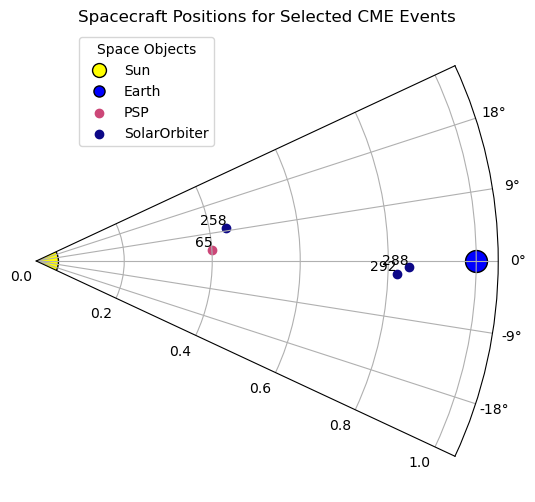

In [121]:
# Keeps the ID with the index at the time of study, since the index changes as the catalogue updates
id_map = {
    'ICME_PSP_MOESTL_20230917_02': 65,
    'ICME_SOLO_MOESTL_20220311_01': 258,
    'ICME_SOLO_MOESTL_20211103_01': 288,
    'ICME_SOLO_MOESTL_20211030_01': 292
}

# Extract relevant columns after filtering
times = final_four_CMEs['icme_start_time']
spacecraft = final_four_CMEs['sc_insitu']
distances = final_four_CMEs['mo_sc_heliodistance']
longitudes = final_four_CMEs['mo_sc_long_heeq']

# Convert longitudes to radians for polar plotting
longitudes_rad = np.radians(longitudes)  # Ensure it's in radians

# Create a polar plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})

# Set theta (angle) limits to focus only on the relevant section
ax.set_thetamin(-25)
ax.set_thetamax(25)

# Plot Sun and Earth with large Size (for visualisation)
sun_plot = ax.scatter(0, 0, color='yellow', marker='o', s=1000, edgecolors='black')  # Sun
earth_plot = ax.scatter(0, 1, color='blue', marker='o', s=250, edgecolors='black')   # Earth


# Assign a unique colour to each spacecraft 
unique_spacecraft = list(set(spacecraft))  
colour_map = plt.colormaps.get_cmap("plasma")  

# Map colours to spacecraft
spacecraft_colours = {sc: colour_map(i / len(unique_spacecraft)) for i, sc in enumerate(unique_spacecraft)}

# Dictionary to store scatter plots for legend
scatter_plots = {}

# Loop through filtered data and add spacecraft positions
for lon, r, sc, idx in zip(longitudes_rad, distances, spacecraft, id_map.values()):  
    colour = spacecraft_colours[sc]  
    scatter = ax.scatter(lon, r, color=colour, label=sc)  
    ax.text(lon, r, f"{idx}", fontsize=10, ha='right', va='bottom')

    # Add one scatter plot per spacecraft to the legend
    if sc not in scatter_plots:
        scatter_plots[sc] = scatter  

# Create legend markers for Sun and Earth
sun_legend = Line2D([0], [0], marker='o', color='yellow', label='Sun',
                    markersize=10, markeredgecolor='black', linestyle='None')
earth_legend = Line2D([0], [0], marker='o', color='blue', label='Earth',
                      markersize=8, markeredgecolor='black', linestyle='None')

# Combine with spacecraft handles
legend_handles = [sun_legend, earth_legend] + list(scatter_plots.values())
legend_labels = ["Sun", "Earth"] + list(scatter_plots.keys())

# Create the legend
ax.legend(handles=legend_handles, labels=legend_labels, title="Space Objects",
          loc="upper right", bbox_to_anchor=(0.4, 1.0))

ax.set_title("Spacecraft Positions for Selected CME Events")
ax.grid(True)
#plt.savefig('spacecraft_pos.pdf')

# Show plot
plt.show()


## Download and plot the in-situ data for the selected CMEs


Fetching data for ICME_PSP_MOESTL_20230917_02 (PSP)...
Results from 1 Provider:

2 Results from the CDAWEBClient:
Source: https://cdaweb.gsfc.nasa.gov/index.html

     Dataset              Start time               End time       
------------------ ----------------------- -----------------------
PSP_FLD_L2_MAG_RTN 2023-09-17 12:00:00.000 2023-09-17 17:59:59.000
PSP_FLD_L2_MAG_RTN 2023-09-17 18:00:00.000 2023-09-17 23:59:59.000




Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

2025-04-23 15:40:41 - sunpy - WARNING: SunpyUserWarning: astropy did not recognize units of "Samples/cycle". Assigning dimensionless units. If you think this unit should not be dimensionless, please raise an issue at https://github.com/sunpy/sunpy/issues


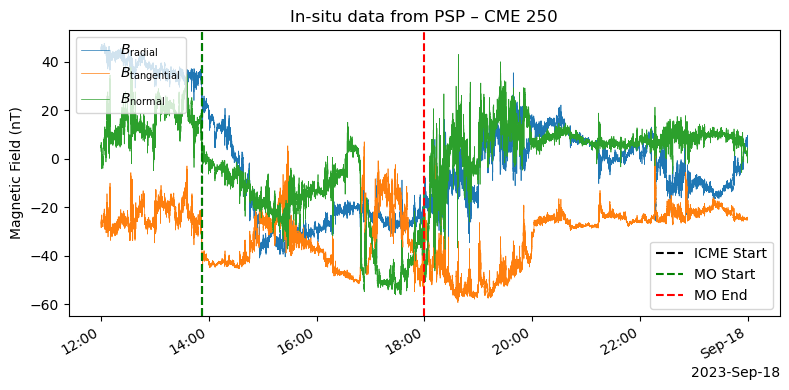


Fetching data for ICME_SOLO_MOESTL_20220311_01 (SolarOrbiter)...
Results from 1 Provider:

2 Results from the CDAWEBClient:
Source: https://cdaweb.gsfc.nasa.gov/index.html

       Dataset                Start time               End time       
---------------------- ----------------------- -----------------------
SOLO_L2_MAG-RTN-NORMAL 2022-03-11 00:00:00.000 2022-03-11 23:59:59.000
SOLO_L2_MAG-RTN-NORMAL 2022-03-12 00:00:00.000 2022-03-12 23:59:59.000




Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

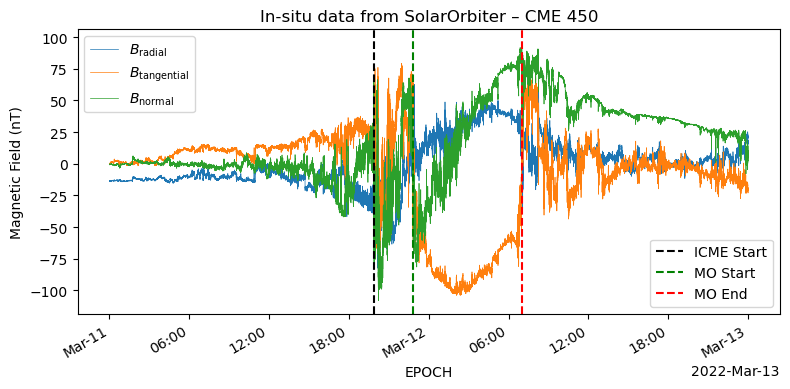


Fetching data for ICME_SOLO_MOESTL_20211103_01 (SolarOrbiter)...
Results from 1 Provider:

2 Results from the CDAWEBClient:
Source: https://cdaweb.gsfc.nasa.gov/index.html

       Dataset                Start time               End time       
---------------------- ----------------------- -----------------------
SOLO_L2_MAG-RTN-NORMAL 2021-11-03 00:00:00.000 2021-11-03 23:59:59.000
SOLO_L2_MAG-RTN-NORMAL 2021-11-04 00:00:00.000 2021-11-04 23:59:59.000




Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

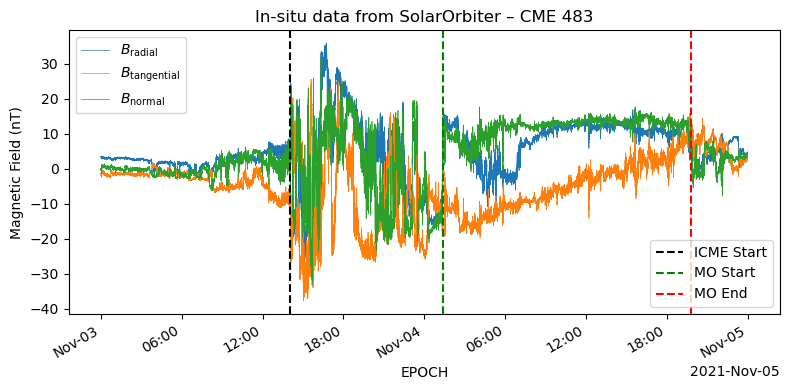


Fetching data for ICME_SOLO_MOESTL_20211030_01 (SolarOrbiter)...
Results from 1 Provider:

2 Results from the CDAWEBClient:
Source: https://cdaweb.gsfc.nasa.gov/index.html

       Dataset                Start time               End time       
---------------------- ----------------------- -----------------------
SOLO_L2_MAG-RTN-NORMAL 2021-10-30 00:00:00.000 2021-10-30 23:59:59.000
SOLO_L2_MAG-RTN-NORMAL 2021-10-31 00:00:00.000 2021-10-31 23:59:59.000




Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

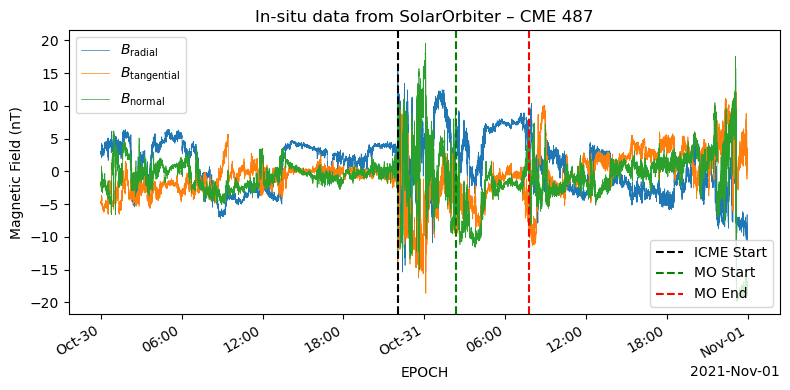

In [123]:
# Define spacecraft datasets and plotting metadata
spacecraft_data = {
    'PSP': {
        'dataset': 'PSP_FLD_L2_MAG_RTN',
        'columns': ['psp_fld_l2_mag_RTN_0', 'psp_fld_l2_mag_RTN_1', 'psp_fld_l2_mag_RTN_2'],
        'rtn_labels': {
            'psp_fld_l2_mag_RTN_0': r"$B_{\text{radial}}$",
            'psp_fld_l2_mag_RTN_1': r"$B_{\text{tangential}}$",
            'psp_fld_l2_mag_RTN_2': r"$B_{\text{normal}}$"
        }
    },
    'SolarOrbiter': {
        'dataset': 'SOLO_L2_MAG-RTN-NORMAL',
        'columns': ['B_RTN_0', 'B_RTN_1', 'B_RTN_2'],
        'rtn_labels': {
            'B_RTN_0': r"$B_{\text{radial}}$",
            'B_RTN_1': r"$B_{\text{tangential}}$",
            'B_RTN_2': r"$B_{\text{normal}}$"
        }
    }
}

# Loop over each CME event for the final four CME events
for idx, row in final_four_CMEs.iterrows():
    # Get the spacecraft name and downloads the correct dataset
    spacecraft = row['sc_insitu']
    dataset_name = spacecraft_data[spacecraft]['dataset']
    columns = spacecraft_data[spacecraft]['columns']
    rtn_labels = spacecraft_data[spacecraft]['rtn_labels']
    # Format start and end times 
    start_time_str = pd.to_datetime(row['icme_start_time']).strftime('%Y/%m/%d %H:%M:%S')
    end_time_str = pd.to_datetime(row['mo_end_time']).strftime('%Y/%m/%d %H:%M:%S')
    trange = a.Time(start_time_str, end_time_str) # Time range to search for Fido


    print(f"\nFetching data for {row['icmecat_id']} ({spacecraft})...")
    result = Fido.search(trange, a.cdaweb.Dataset(dataset_name))
    print(result)
    # If the data is found then it fetches it and begins to plot the in-situ data 
    if result.file_num > 0:
    
        # Download the data files and load them into a TimeSeries object
        files = Fido.fetch(result)
        timeseries = TimeSeries(files, concatenate=True)

       # Plot magnetic field components
        fig, ax = plt.subplots(figsize=(8, 4))
        lines = timeseries.plot(axes=ax, columns=columns, linewidth=0.5)
        
        # Capture handles and labels for RTN magnetic field components
        rtn_handles, rtn_labels_list = ax.get_legend_handles_labels()
        rtn_new_labels = [rtn_labels.get(lbl, lbl) for lbl in rtn_labels_list]
        
        # Add vertical lines for key timestamps to show the start of the ICME and the FR
        time_handles = []
        time_labels = []
        for label, time_str, color in [
            ('ICME Start', row['icme_start_time'], 'k'),
            ('MO Start', row['mo_start_time'], 'g'),
            ('MO End', row['mo_end_time'], 'r')
        ]:
            line = ax.axvline(pd.to_datetime(time_str), color=color, linestyle='--', label=label)
            time_handles.append(line)
            time_labels.append(label)
        
        # First legend: RTN components
        legend1 = ax.legend(rtn_handles, rtn_new_labels, loc='upper left', fontsize='medium')
        
        # Second legend: Event timings
        legend2 = ax.legend(time_handles, time_labels, loc='lower right', fontsize='medium')
        # Add both legends to the axes
        ax.add_artist(legend1)
        ax.set_title(f"In-situ data from {row['sc_insitu']} – CME {idx}")
        ax.set_ylabel('Magnetic Field (nT)') 
        
        plt.tight_layout()
        plt.savefig(f"CME_{idx}_{row['sc_insitu']}.pdf", dpi=300, bbox_inches='tight')
        plt.show()


## Search through the list of CMEs on the Sun-Earth line to find Wind only detected CMEs

In [125]:
# Filter for PSP and Solar Orbiter as unable to get in situ data for BepiColombo at the moment
target_spacecraft = ['Wind']
WIND_CMEs = filtered_cmes[filtered_cmes['sc_insitu'].isin(target_spacecraft)].copy()


In [126]:
WIND_CMEs

,icmecat_id,icme_start_time,icme_duration,icme_speed_mean,sc_insitu,mo_start_time,mo_end_time,icme_bmax,mo_bzmean,mo_sc_heliodistance,mo_sc_long_heeq
2,ICME_Wind_MOESTL_20241217_01,2024-12-17T04:28Z,9.80,621.7,Wind,2024-12-17T05:28Z,2024-12-17T14:16Z,32.0,10.0,0.9732,-0.10
4,ICME_Wind_MOESTL_20241207_01,2024-12-07T23:14Z,18.60,353.1,Wind,2024-12-07T23:14Z,2024-12-08T17:50Z,10.2,-1.3,0.9746,-0.17
5,ICME_Wind_MOESTL_20241129_01,2024-11-29T02:14Z,14.90,393.0,Wind,2024-11-29T06:12Z,2024-11-29T17:08Z,16.6,0.5,0.9763,-0.21
8,ICME_Wind_MOESTL_20241114_01,2024-11-14T02:56Z,12.57,372.7,Wind,2024-11-14T04:28Z,2024-11-14T15:30Z,13.2,-1.3,0.9800,-0.25
10,ICME_Wind_MOESTL_20241109_01,2024-11-09T22:00Z,12.97,407.0,Wind,2024-11-09T22:00Z,2024-11-10T10:58Z,12.8,-5.9,0.9812,-0.25
...,...,...,...,...,...,...,...,...,...,...,...
1833,ICME_Wind_NASA_19950405_01,1995-04-05T07:11Z,34.07,338.0,Wind,1995-04-05T17:59Z,1995-04-06T17:15Z,11.2,-0.8,0.9910,-0.14
1834,ICME_Wind_NASA_19950403_01,1995-04-03T06:43Z,30.70,301.6,Wind,1995-04-03T12:45Z,1995-04-04T13:25Z,10.4,1.6,0.9905,-0.14
1835,ICME_Wind_NASA_19950306_01,1995-03-06T02:11Z,24.20,455.5,Wind,1995-03-06T07:11Z,1995-03-07T02:23Z,9.8,4.3,0.9832,-0.01
1836,ICME_Wind_NASA_19950304_01,1995-03-04T00:36Z,26.50,439.7,Wind,1995-03-04T11:23Z,1995-03-05T03:06Z,13.3,-4.9,0.9828,-0.00


In [127]:
# Wind distance in AU
wind_distance = 0.98  # Approximation

# Calculate travel time to WIND (in hours) and ETA
AU_in_km = 149597870.7  # 1 AU in km
def calc_eta(row):
    distance_km = (wind_distance - row["mo_sc_heliodistance"]) * AU_in_km
    speed_kmh = row["icme_speed_mean"]  # in km/s
    time_hours = distance_km / (speed_kmh * 3600)  # convert speed to km/h
    eta = row["icme_start_time"] + timedelta(hours=time_hours)
    return pd.Series({"travel_time_hr": time_hours, "ETA_at_WIND": eta})


final_four_CMEs = final_four_CMEs.copy()

# Convert to a date & time object instead of a string 
final_four_CMEs["icme_start_time"] = pd.to_datetime(final_four_CMEs["icme_start_time"])

# Apply the function 
final_four_CMEs[["travel_time_hr", "ETA_at_WIND"]] = final_four_CMEs.apply(calc_eta, axis=1)

# Compare ETA with WIND CME times to find overlaps
WIND_CMEs["icme_start_time"] = pd.to_datetime(WIND_CMEs["icme_start_time"])
WIND_CMEs["icme_end_time"] = pd.to_datetime(WIND_CMEs["mo_end_time"])

# Function to find matching WIND CMEs for each ETA

# Function with ±24-hour window
def find_matching_wind_cme(eta):
    time_window_start = eta - timedelta(hours=24)
    time_window_end = eta + timedelta(hours=24)
    
    for _, row in WIND_CMEs.iterrows():
        if row["icme_end_time"] >= time_window_start and row["icme_start_time"] <= time_window_end:
            return row["icmecat_id"]
    return None


final_four_CMEs["matching_wind_cme"] = final_four_CMEs["ETA_at_WIND"].apply(find_matching_wind_cme)




In [128]:
# List of specific WIND ICME event IDs to match
matching_wind_cmes = [ 'ICME_Wind_MOESTL_20230919_01', 'ICME_Wind_MOESTL_20220313_01', 'ICME_Wind_MOESTL_20211103_01', 'ICME_Wind_MOESTL_20211031_01']
# Filter the WIND_CMEs DataFrame to include only the matched events
matched_wind_cmes = WIND_CMEs[WIND_CMEs["icmecat_id"].isin(matching_wind_cmes)]
# Display the results 
matched_wind_cmes
# matched_wind_cmes.to_csv("matched_wind_cmes.csv") - save if needed 


,icmecat_id,icme_start_time,icme_duration,icme_speed_mean,sc_insitu,mo_start_time,mo_end_time,icme_bmax,mo_bzmean,mo_sc_heliodistance,mo_sc_long_heeq,icme_end_time
245,ICME_Wind_MOESTL_20230919_01,2023-09-19 14:30:00+00:00,20.90,551.4,Wind,2023-09-19T14:30Z,2023-09-20T11:24Z,10.7,1.5,0.9960,0.19,2023-09-20 11:24:00+00:00
448,ICME_Wind_MOESTL_20220313_01,2022-03-13 10:04:00+00:00,50.10,421.5,Wind,2022-03-13T22:42Z,2022-03-15T12:10Z,27.3,10.7,0.9848,0.25,2022-03-15 12:10:00+00:00
482,ICME_Wind_MOESTL_20211103_01,2021-11-03 19:40:00+00:00,32.77,671.5,Wind,2021-11-04T06:30Z,2021-11-05T04:26Z,24.9,6.8,0.9834,-0.04,2021-11-05 04:26:00+00:00
485,ICME_Wind_MOESTL_20211031_01,2021-10-31 09:32:00+00:00,5.30,431.9,Wind,2021-10-31T10:04Z,2021-10-31T14:50Z,12.5,-0.2,0.9844,-0.01,2021-10-31 14:50:00+00:00


Start: 2023/09/19 14:30:00 End: 2023/09/20 11:24:00
Fido result:
 Results from 1 Provider:

2 Results from the CDAWEBClient:
Source: https://cdaweb.gsfc.nasa.gov/index.html

   Dataset           Start time               End time       
------------- ----------------------- -----------------------
WI_H3-RTN_MFI 2023-09-19 00:00:30.000 2023-09-19 23:59:30.000
WI_H3-RTN_MFI 2023-09-20 00:00:30.000 2023-09-20 23:59:30.000




Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

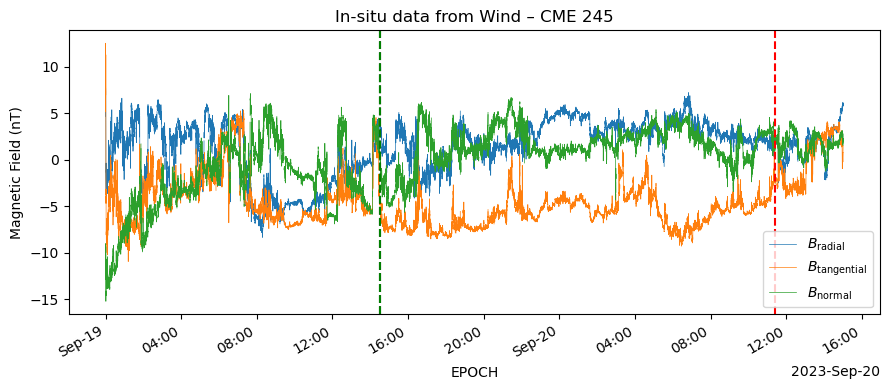

Start: 2022/03/13 10:04:00 End: 2022/03/15 12:10:00
Fido result:
 Results from 1 Provider:

3 Results from the CDAWEBClient:
Source: https://cdaweb.gsfc.nasa.gov/index.html

   Dataset           Start time               End time       
------------- ----------------------- -----------------------
WI_H3-RTN_MFI 2022-03-13 00:00:30.000 2022-03-13 23:59:30.000
WI_H3-RTN_MFI 2022-03-14 00:00:30.000 2022-03-14 23:59:30.000
WI_H3-RTN_MFI 2022-03-15 00:00:30.000 2022-03-15 23:59:30.000




Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

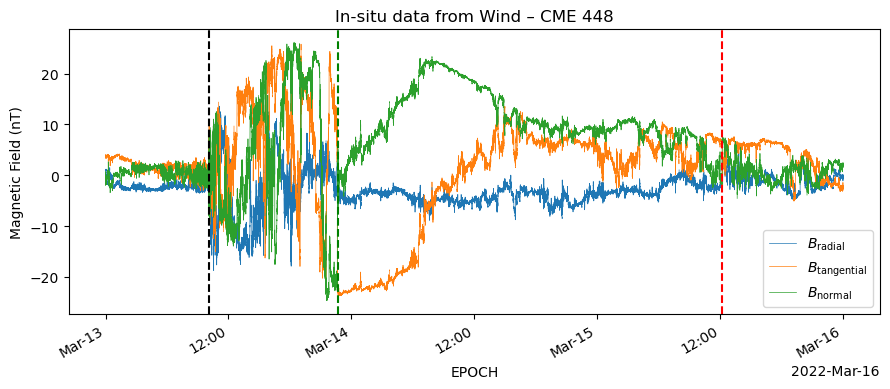

Start: 2021/11/03 19:40:00 End: 2021/11/05 04:26:00
Fido result:
 Results from 1 Provider:

3 Results from the CDAWEBClient:
Source: https://cdaweb.gsfc.nasa.gov/index.html

   Dataset           Start time               End time       
------------- ----------------------- -----------------------
WI_H3-RTN_MFI 2021-11-03 00:00:30.000 2021-11-03 23:59:30.000
WI_H3-RTN_MFI 2021-11-04 00:00:30.000 2021-11-04 23:59:30.000
WI_H3-RTN_MFI 2021-11-05 00:00:30.000 2021-11-05 23:59:30.000




Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

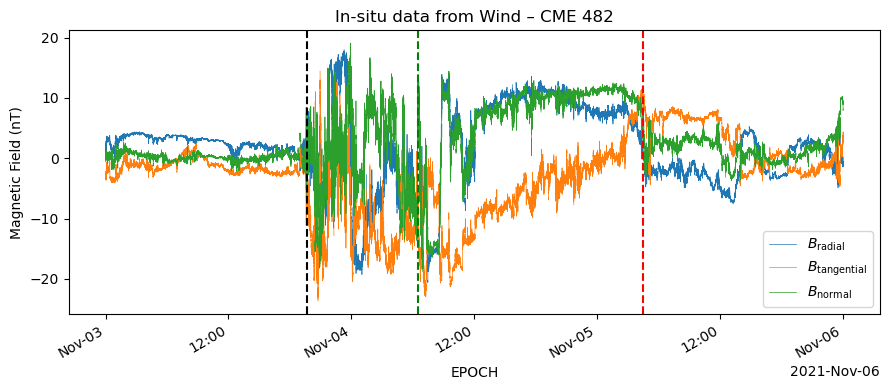

Start: 2021/10/31 09:32:00 End: 2021/10/31 14:50:00
Fido result:
 Results from 1 Provider:

1 Results from the CDAWEBClient:
Source: https://cdaweb.gsfc.nasa.gov/index.html

   Dataset           Start time               End time       
------------- ----------------------- -----------------------
WI_H3-RTN_MFI 2021-10-31 00:00:30.000 2021-10-31 23:59:30.000




Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

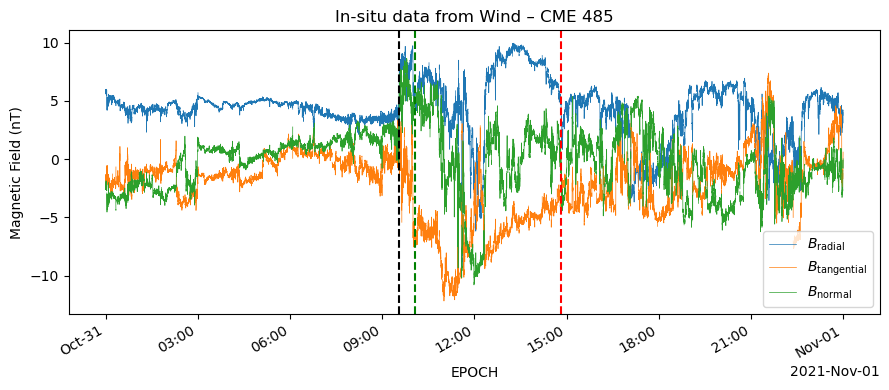

In [129]:
# Change the labels to the RTN corresponding components
rtn_labels = {
    'B3RTN_0': r"$B_{\text{radial}}$",
    'B3RTN_1': r"$B_{\text{tangential}}$",
    'B3RTN_2': r"$B_{\text{normal}}$"
}

# Loop through each matching CME and plot with vertical lines
for idx, row in matched_wind_cmes.iterrows():
    # Convert times to strings
    icme_start_str = pd.to_datetime(row['icme_start_time']).strftime('%Y/%m/%d %H:%M:%S')
    mo_start_str = pd.to_datetime(row['mo_start_time']).strftime('%Y/%m/%d %H:%M:%S')
    mo_end_str = pd.to_datetime(row['mo_end_time']).strftime('%Y/%m/%d %H:%M:%S')

    # Determine a timerange and the dataset which is to be downloaded 
    trange = a.Time(icme_start_str, mo_end_str)
    dataset = a.cdaweb.Dataset('WI_H3-RTN_MFI')

    result = Fido.search(trange, dataset)
    print("Start:", icme_start_str, "End:", mo_end_str)
    print("Fido result:\n", result)

    if result.file_num > 0:
        files = Fido.fetch(result)
        wind_insitu = TimeSeries(files, concatenate=True)

        # Plot magnetic field components
        fig, ax = plt.subplots(figsize=(9, 4))
        wind_insitu.plot(axes=ax, columns=['B3RTN_0', 'B3RTN_1', 'B3RTN_2'], linewidth=0.5)

        # Add vertical lines for event markers
        for label, time_str, color in [
            ('ICME Start', row['icme_start_time'], 'k'),
            ('MO Start', row['mo_start_time'], 'g'),
            ('MO End', row['mo_end_time'], 'r')
        ]:
            time_dt = pd.to_datetime(time_str)
            ax.axvline(time_dt, color=color, linestyle='--')

        ax.set_title(f"In-situ data from {row['sc_insitu']} – CME {idx}")

        # Modify legend labels
        handles, labels = ax.get_legend_handles_labels()
        new_labels = [rtn_labels.get(lbl, lbl) for lbl in labels]
        ax.legend(handles, new_labels, loc="lower right", fontsize="medium", frameon=True)
        ax.set_ylabel('Magnetic Field (nT)')
        ax.set_xlabel('EPOCH')

        plt.tight_layout()
        plt.savefig(f"CME_Wind_{idx}.pdf", dpi=300, bbox_inches='tight')
        plt.show()
